## Classification and Probabilistic learning

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

We turn our attention to **classification**[^classification]. Classification tries to predict, which of a small set of classes, a sample in a population belongs to. Mathematically, the aim is to find $y$, a **label** based on knowing a feature vector $\x$. For instance, consider predicting gender from seeing a person's face, something we do fairly well as humans. To have a machine do this well, we would typically feed the machine a bunch of images of people which have been labelled "male" or "female" (the training set), and have it learn the gender of the person in the image. Then, given a new photo, the algorithm learned returns us the gender of the person in the photo.

There are different ways of making classifications. One idea is shown schematically in the image \ref{onelinesplit} below, where we find a line that divides "things" of two different types in a 2-dimensional feature space.

![Splitting using a single line](images/onelinesplit.png)

In this chapter PARA. 

In [95]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [155]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [156]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

###Setting up some code

Lets make a small diversion, though, and set some code up for classification using cross-validation so that we can easily run classification models in scikit-learn. We first set up a function `cv_optimize` which takes a classifier `clf`, a grid of hyperparameters (such as a complexity parameter or regularization parameter as in the last chapter) implemented as a dictionary `parameters`, a training set (as a samples x features array) `Xtrain`, and a set of labels `ytrain`. The code takes the traning set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each foldfor us. It prints the best value of the parameters, and retuens the best classifier to us.

In [115]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best


We then use this best classifier to fit the entire training set. This is done inside the `do_classify` function which takes a dataframe `indf` as input. It takes the columns in the list `featurenames` as the features used to train the classifier. The column `targetname` sets the target. The classification is done by setting those samples for which `targetname` has value `target1val` to the value 1, and all others to 0. We split the dataframe into 80% training and 20% testing by default, standardizing the dataset if desired. (Standardizing a data set involves scaling the data so that it has 0 mean and is described in units of its standard deviation, the reasons for this transform are talked about in chapter REF). We then train the model on the training set using cross-validation. Having obtained the best classifier using `cv_optimize`, we retrain on the entire training set and calculate the training and testing accuracy, which we print. We return the split data and the trained classifier.

In [116]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

We'll use a dataset of heights and weights of mles and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [117]:
df=pd.read_csv("data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


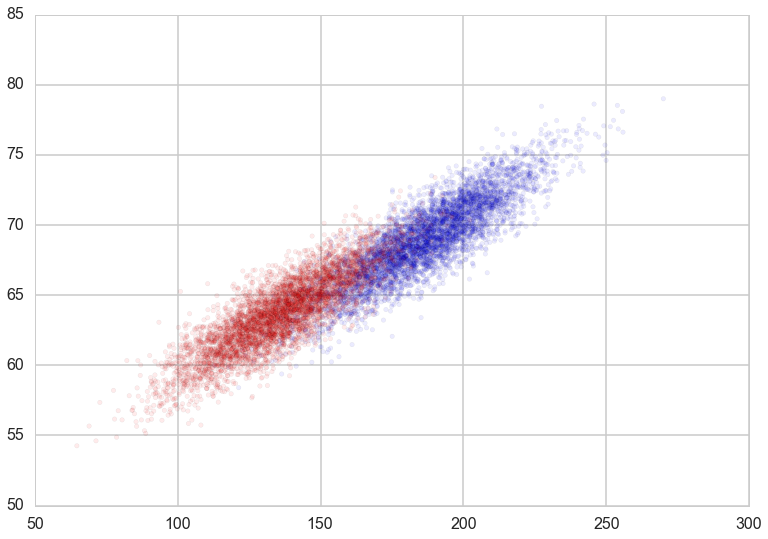

In [119]:
plt.scatter(df.Weight, df.Height, c=[cm_bright.colors[i] for i in df.Gender=="Male"], alpha=0.08);

We can see, unsurprisingly, that there are two clusters of dense areas in the plot, corresponding to females (lower in height and weight) and males. A scatterplot colored by gender brings out the structure of the data:

###How to Classify

In chapter REF, we used a squared error loss function along with Empirical Risk Minimization (ERM) to carry out regression. The idea there was to calculate this risk on the training set and minimize it. Then the hope was that on the population, or any testing set representative of it, the out-of-sample risk was similar in size to the in-sample training risk, and thus small.

What might be an appropriate risk for classification? One immediately comes to mind: the fraction of misclassified samples. 

For each sample this is equivalent to choosing the 1-0 loss:

$$l = \mathbf{1}_{h \ne y}.$$

where $h$ is the classification **decision** we make (for regression we used $l = (h-y)^2$). The symbol $\mathbf{1}$ means that if $h$ is not equal to the "true" value of the point $y$, penalize by 1. Then the risk is:

$$ R_{\cal{D}}(h(x)) = \frac{1}{N} \sum_{y_i \in \cal{D}} l = \frac{1}{N} \sum_{y_i \in \cal{D}} \mathbf{1}_{h \ne y_i} $$

Thus if 5 out of 50 samples are misclassified, then the risk is 0.1. This of course means that 90% of the samples are correctly classified. This number is called the **accuracy score** or **utility**:

$$ U_{\cal{D}}(h(x))  = \frac{1}{N} \sum_{y_i \in \cal{D}} \mathbf{1}_{h = y_i} $$

It can be output in `sklearn` using the `score` function of a classifier. It is what we print in the function `do_classify` defined above, on both the training and test sets.

###Logistic Regression

It tuens out that minimizing the 1-0 loss with respect to some parameters of our model is very hard to do, for technical reasons of the 1-0 loss not being a convex loss (more about this in chapter REF). Thus it makes sense tolook for alternate approaches. One approach that we know about already is linear regression.

We could approach classification as linear regression, there the class, 0 or 1, is the target variable $y$. But this ignores the fact that our output $y$ is discrete valued, and futhermore, the $y$ predicted by linear regression will in general take on values less than 0 and greater than 1. Thus this does not seem like a very good idea.

But what if we could change the form of our hypotheses $h(x)$ instead?

The idea behind logistic regression is very simple. We want to draw a line in feature space that divides the '1' samples from the '0' samples, just like in the diagram above. In other words, we wish to find the "regression" line which divides the samples. Now, a line has the form $w_1 x_1 + w_2 x_2 + w_0 = 0$ in 2-dimensions. On one side of this line we have 

$$w_1 x_1 + w_2 x_2 + w_0 \ge 0,$$

and on the other side we have 

$$w_1 x_1 + w_2 x_2 + w_0 < 0.$$ 

Our classification rule then becomes:

\begin{eqnarray*}
y = 1 &if& \v{w}\cdot\v{x} \ge 0\\
y = 0 &if& \v{w}\cdot\v{x} < 0
\end{eqnarray*}

where $\v{x}$ is the vector $\{1,x_1, x_2,...,x_n\}$ where we have also generalized to more than 2 features.

What hypotheses $h$ can we use to achieve this? One way to do so is to use the **sigmoid** function:

$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

This function is plotted below:

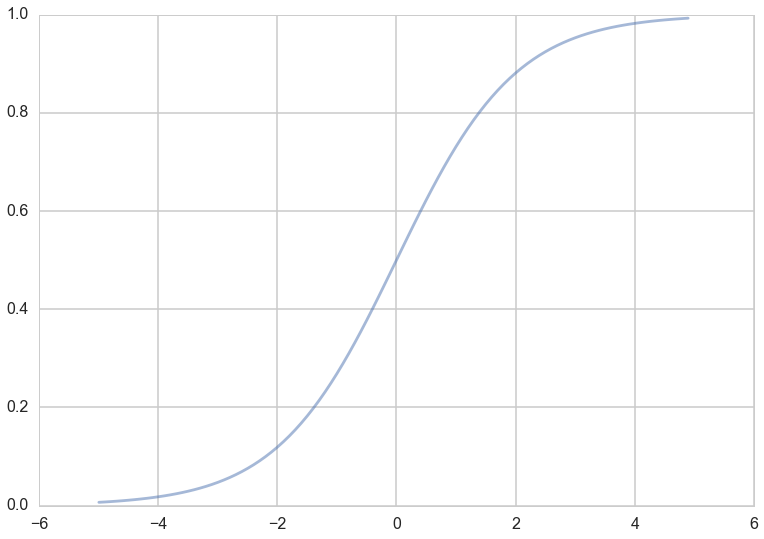

In [120]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)
plt.plot(zs, h(zs), alpha=0.5);

So we then come up with our rule by identifying:

$$z = \v{w}\cdot\v{x}.$$

Then $h(\v{w}\cdot\v{x}) \ge 0.5$ if $\v{w}\cdot\v{x} \ge 0$ and $h(\v{w}\cdot\v{x}) \lt 0.5$ if $\v{w}\cdot\v{x} \lt 0$, and:

\begin{eqnarray*}
y = 1 &if& h(\v{w}\cdot\v{x}) \ge 0.5\\
y = 0 &if& h(\v{w}\cdot\v{x}) \lt 0.5.
\end{eqnarray*}



We will show soon that this identification can be achieved by minimizing a loss in the ERM framework called the **log loss** :

$$ R_{\cal{D}}(\v{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right )$$

We can see why this might be a good idea by plotting the log loss against the 1-0 loss for a '0' misclassified as a '1':

DIAGRAM+TEXT

More generally we add a regularization term (as in the ridge regression in the previous chapter):

$$ R_{\cal{D}}(\v{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right ) + \frac{1}{C} \v{w}\cdot\v{w},$$

where $C$ is the regularization strength (corresponding to $1/\alpha$ from the Ridge case), and smaller values of $C$ mean stronger regularization. As before, the regularization tries to prevent features from having terribly high weights, thus implementing a form of feature selection. 

How did we come up with this loss? We'll come back to that, but let us see how logistic regression works out. 

In [121]:
from sklearn.linear_model import LogisticRegression
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, df, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


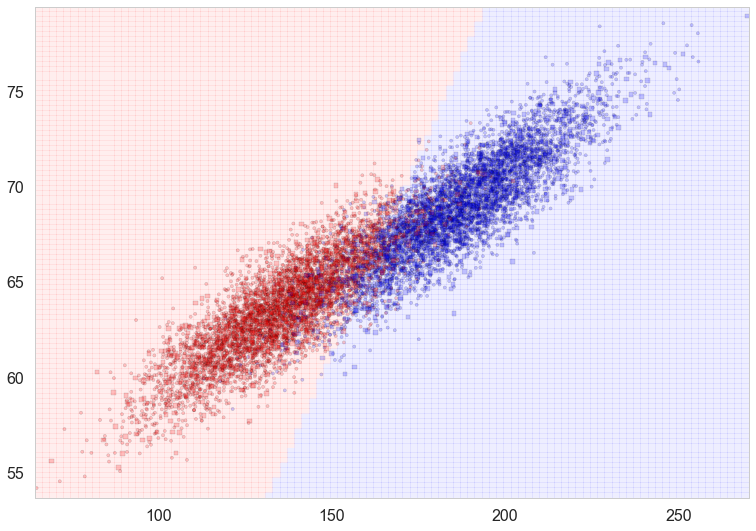

In [157]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In the figure here showing the results of the logistic regression, we plot the actual labels of both the training(circles) and test(squares) samples. The 0's (females) are plotted in red, the 1's (males) in blue. We also show the classification boundary, a line (to the resolution of a grid square). Every sample on the red background side of the line will be classified female, and every sample on the blue side, male. Notice that most of the samples are classified well, but there are misclassified people on both sides, as evidenced by leakage of dots or squares of one color ontothe side of the other color. Both test and traing accuracy are about 92%.

###The probabilistic interpretaion

Remember we said earlier that if $h > 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h(\v{w}\cdot\v{x})$ with the probability that the sample is a '1' ($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probabilty of being a '1' is $\ge 0.5$.

So suppose we say then that the probability of $y=1$ for a given $\v{x}$ is given by $h(\v{w}\cdot\v{x})$?

Then, the conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\v{x}$ are:

\begin{eqnarray*}
P(y=1 | \v{x}) &=& h(\v{w}\cdot\v{x}) \\
P(y=0 | \v{x}) &=& 1 - h(\v{w}\cdot\v{x}).
\end{eqnarray*}

These two can be written together as

$$P(y|\v{x}, \v{w}) = h(\v{w}\cdot\v{x})^y \left(1 - h(\v{w}\cdot\v{x}) \right)^{(1-y)} $$

Then multiplying over the samples we get the probability of the training $y$ given $\v{w}$ and the $\v{x}$:

$$P(y|\v{x},\v{w}) = P(\{y_i\} | \{\v{x}_i\}, \v{w}) = \prod_{y_i \in \cal{D}} P(y_i|\v{x_i}, \v{w}) = \prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}$$

Why use probabilities? Earlier, in chapter REF, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\dat$ was generated from  a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, and since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y | x) P(x) ,$$

and can obtain our joint probability ($P(x, y))$.

Indeed its important to realize that a particular training set can be thought of as a draw from some "true" probability distribution (just as we did when showing the hairy variance diagram in chapter REF). If for example the probability of classifying a test sample as a '1' was 0.1, and it turns out that the test sample was a '0', it does not mean that this model was necessarily wring. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. And furthermore, we can quantify this accuracy.

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. There are business reasons for this too. Consider the example of customer "churn": you are a cell-phone company and want to know, based on some of my purchasing habit and characteristic "features" if I am a likely defector. If so, you'll offer me an incentive not to defect. In this scenario, you might want to know which customers are most likely to defect, or even more precisely, which are most likely to respond to incentives. Based on these probabilities, you could then spend a finite marketing budget wisely.

####Maximizing the probability of the training set.

Now if we maximize $$P(y|\v{x},\v{w})$$, we will maximize the chance that each point is classified correctly, which is what we want to do. While this is not exactly the same thing as maximizing the 1-0 training risk, it is a principled way of obtaining the highest probability classification. This process is called **maximum likelihood** estimation since we are maximising the **likelihood of the training data y**, 

$$\like = P(y|\v{x},\v{w}).$$ 

Maximum likelihood is one of the corenerstone methods in statistics, and is used to estimate probabilities of data. We shall come back to it in chapter REF.

We can equivalently maximize 

$$\loglike = log(P(y|\v{x},\v{w}))$$ 

since the natural logarithm $log$ is a monotonic function (see chapter REF). This is known as maximizing the **log-likelihood**. Thus we can equivalently *minimize* a risk that is the negative of  $log(P(y|\v{x},\v{w}))$:

$$R_{\cal{D}}(h(x)) = -\loglike = -log \like = - log(P(y|\v{x},\v{w})).$$


Thus

\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -log\left(\prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} log\left(h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} log\,h(\v{w}\cdot\v{x_i})^{y_i} + log\,\left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right )
\end{eqnarray*}
                  
This is exactly the risk we had above, leaving out the regularization term (which we shall return to later) and was the reason we chose it over the 1-0 risk. 

Notice that this little process we carried out above tells us something very interesting: **Probabilistic estimation using maximum likelihood is equivalent to Empiricial Risk Minimization using the negative log-likelihood**, since all we did was to minimize the negative log-likelihood over the training samples.

`sklearn` will return the probabilities for our samples, or for that matter, for any input vector set $\{\v{x}_i\}$, i.e. $P(y_i | \v{x}_i, \v{w})$:

In [138]:
clf_l.predict_proba(Xtest_l)

array([[ 0.29274782,  0.70725218],
       [ 0.96971033,  0.03028967],
       [ 0.41249576,  0.58750424],
       ..., 
       [ 0.28210907,  0.71789093],
       [ 0.99666666,  0.00333334],
       [ 0.04644585,  0.95355415]])

###Discriminative classifier

Logistic regression is what is known as a **discriminative classifier**. Let us plot the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

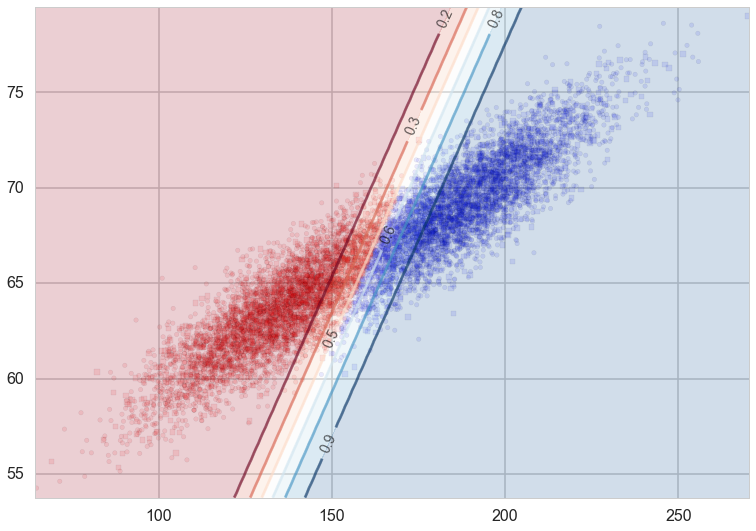

In [161]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);

Notice that lines of equal probability, as might be expected are stright lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (male), otherwise it classifies the sample to be class '0'. Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

This notion of trying to obtain the line or boundary of demarcation is what is called a **discriminative** classifier. The algorithm tries to find a decision boundary that separates the males from the females. To classify a new sample as male or female, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\v{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\v{x},\v{w})$?

###Generative Classifier

There is another way to tackle the problem of classification. It involves finding $P(\v{x} | y)$, the class conditional probability. Consider that heights and weights of males and females might be expected to be distributed using a bell curve. You might have heard of the reasons for this: so many things go into these heights/weights that the net effect is for them to be distributed as a bell curve, according to the central limit theorem (see chapter REF). So why not use this additional information and model the heights and weights of males and females separately as 2-dimensional bell curves or **Normal Distributions**. In other words:

$$p(height, wieght | male ) = Bell Curve$$

centered at the mean height, weight for males, and a similar equation holds for females. This is exactly what the linear discriminant analysis classifier does.  Lets run it, only on tne training set. What we are doing is fitting the male and female sections of the training set separately, getting two 2-D bell curves, and then inverting as above to decide how to classify new samples from the testing set. (We dont cross-validate here as we are currently not fitting any hyperparameters).

In [162]:
from sklearn.lda import LDA
clflda = LDA(solver="svd", store_covariance=True)
clflda.fit(Xtrain_l, ytrain_l)



LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
  store_covariance=True, tol=0.0001)

In [76]:
#from REF
from scipy import linalg

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell.set_clip_box(splot.bbox)
    ell1 = mpl.patches.Ellipse(mean, 1 * v[0] ** 0.5, 1 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell1.set_clip_box(splot.bbox)
    ell3 = mpl.patches.Ellipse(mean, 3 * v[0] ** 0.5, 3 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell3.set_clip_box(splot.bbox)
    #ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.add_artist(ell1)
    splot.add_artist(ell3)


    #splot.set_xticks(())
    #splot.set_yticks(())
def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')
#plt.bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0, mux=0.0, muy=0.0, sigmaxy=0.0)¶

We plot ellipses for equal probability contours of the two individual $P(\v{x}|y)$, the $P(height, weight | male)$ and the $P(height, weight | female)$. We also plot the discriminant line created by inverting these probabilities using Bayes theorem: we once again classify a sample as male if $P(male | height, weight \gt 0.5$ (which will ensure that $P(female | height, weight) < 0.5$ since both must add to 1).

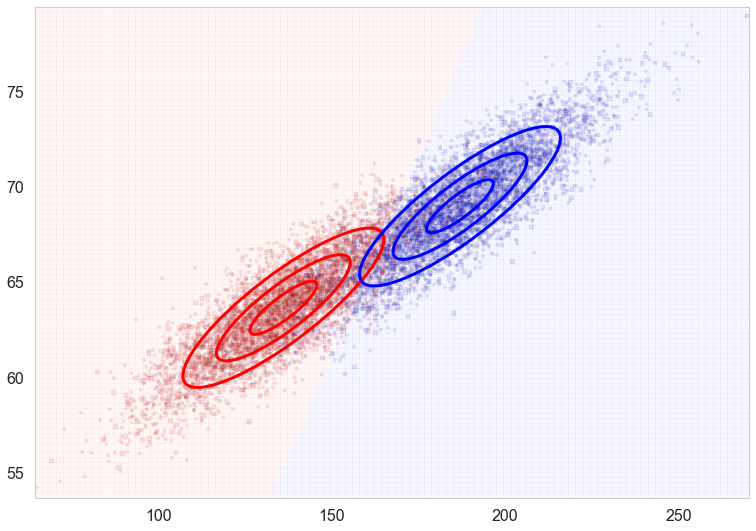

In [163]:
plt.figure()
ax=plt.gca()
spl,_,_=points_plot(ax,Xtrain_l, Xtest_l, ytrain_l, ytest_l, clflda)
plot_lda_cov(clflda, spl)


Whats happenning here? We have estimated $P(\v{x} | y, \theta_y)$ where we use $\theta_y$ to designate the parameters of the fit (the parameters of the female and male bell curves); the subscript indicates we are fitting a separate parameter set for each class.

We can then use Bayes theorem (which we briefly talked about in chapter REF) to invert to find $P(y | \v{x})$, the probability we really want thus:

$$P(y | \v{x}) = \frac{P(\v{x} | y, \theta_{y})}{P(x)} = \frac{P(\v{x} | y) P(y)}{\sum_{y} P(\v{x} | y, \theta_{y})P(y)} .$$

Notice from the first term above that the denominator $P(\v{x})$ does not involve the parameters, it is simply the input distribution of the features. As such, it is not needed in the prediction process.

For our special case of two classes:

$$P(y = c_1 | \v{x}) = \frac{P(\v{x} | y = c_1, \theta_1) P(y=c_1)}{P(\v{x} | y = c_1, \theta_1) P(y=c_1) + P(\v{x} | y = c_0, \theta_0) P(y=c_0)}$$

In other words, we first look at males, and build a model of the features for the males. Then we do a similar thing for females. To classify a new sample, we match it against the model for males, and then the model for females, and user Bayes theorem to see if the new sample more likely looks like the males rather than the females from the training set. 

Another way to think about this is that you can **generate** or simulate a new male or female sample from this model $P(\v{x} | y, \theta_y)$ of males or females respectively. The idea is that you first toss a (possibly biased) coin which depends on $P(y=c_1)$, the "prior" probability of a sample being male or female. Once that coin has landed male or female ("once the draw has been made"), generate a sample in feature space using $P(\v{x}|what landed)$. For example, if the coin landed female, now draw a height and weight according to $$P(height, wieght | female )$$. Thus there is a *story* for how to generate samples in such models. If this story is the "correct" or "nearly correct" one, this is likely to be a very good model, and furthermore, we can draw new training sets to check variance and other measures of our classifier's accuracy.

You can see three important aspects of this method from these formulae already. First, you model the classes separately. Secondly, the formula involves $P(y)$, the prior probability of the sample being in the class, provided you havent seen any testing data. This is usually just taken to be the fraction of a particular class in the training sample. 

Being able to fold this information is key when the classes are very imbalanced in the training data set. For example, consider again the case of trying to predict if a customer will "churn". Typically churn rates are low, of the order of 2-3%.In this case having the prior probabilities of churning and not-churning, and modelling thse groups separately in a generative classifier is very useful: it might be hard for a discriminative classifier to draw a boundary between many many samples on one side and just a few on the other: one might rightly expect this boundary to be a bit fragile.

The third thing is probably obvious and a bit uncomfortable to you: we are being asked to provide much more information: the priors, the individual class models, all of that. It would seem that to get the same kind of classification we are being asked to provide more information.

This is true, but it is not a bad thing when the assumptions that go into individual models are well founded, such as in the case of our male and female heights and weights here. 

We can also plot the output of `predict_proba` and we see something interesting: we get back exactly the same probability lines that we got using logistic regression. Indeed, LDA is the generative conterpart of Logistic regression. It is possible to prove this but we shall not do so here (see REF).

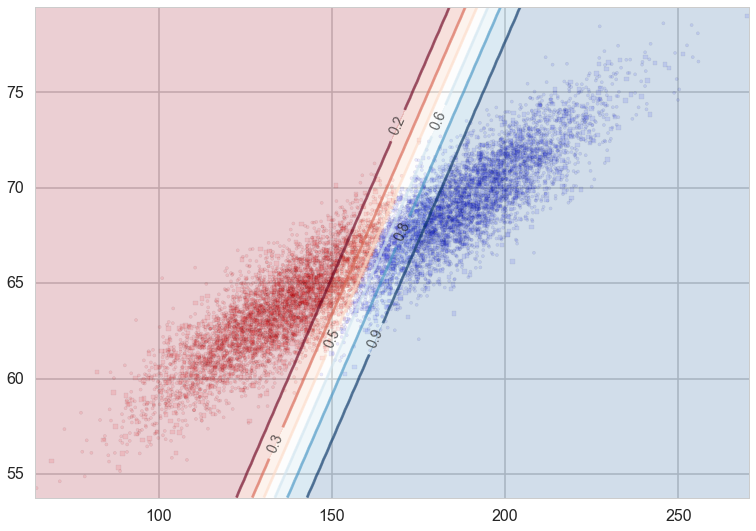

In [164]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clflda);

The important point here is that many generative models, including those with Poisson Likelihoods and Naive Bayes Models have Logistic Regression as their discriminative counterpart. This means that on inverting the $P(\v{x}|y)$ using Bayes theorem, we get back Logistic Regression. Thus Logistic regression if a relatively robust model, insensitive to many modelling assumptions. This is a big reason to use such Discriminative models.

But if $p(\v{x}|y)$ is indeed Normal, as is here for our two classes of male and female, LDA is what is known as **asymptotically efficient**. This means that for large amounts of training data, it can be proved that no model can be better than LDA for the estimation of theprobability we'd like to use to get our classification,  $p(y|\v{x})$. In particular, it can be shown that LDA will outperform Logistic regression, even for small traing set sizes.

Furthermore, we can directly include information about the class priors or frequencies, as in the very asymmetric case of customer churn. So, which to use when? This is a question we shall address in more detail later in this book, as we look in more detail at individual datasets.

Finally note that there is another major advantage of a generative classifier. We can sum up over class conditional probably density weighted by the priors to estimate the input density from the probability marginalization formula.

$$P(x) = \sum_y P(x|y)P(y)$$

This is not surprising. A lot of elbow-grease went into the generative classifier since we had to model so much. It should pay some dividend.

###The multiple risks in classification

With all this talk about probabilities, maximizing likelihood, and negative log-likelihoods as equivalent risks, you might be wondering if we have bitten the shark. Our original premise was a very simple empirical risk minimization (ERM). We just took all the points in the training or test set, and summed up the risk over them, dividing by the number of points in the set. Here we seem to be talking about solving a much harder problem, the estimation of probabilities.

We have some flavor of this simple minimization in these new fangled generative and discriminative approaches, since we do use ERM on the training set with the negatice log-likelihood as the risk. But we appear to have lost the direct notion of function estimation that we had proposed in the regression case in chapter REF. Instead we are indulging in probability estimation with a notion that a probability > 0.5 (in the two class case) is the key to making a classification.

Probability comes in because of stochastic noise and our incomplete knowledge about the world. Minimizing risk is an idea which works (as we saw in the noiseless regression case) even without any stochastic noise. Where do these two ideas meet? 

We minimized a risk (maximised likelihood) to estimate probability in both Logistic Regression (log-loss) and LDA above. This risk is called the **Estimation Risk**. But there is a second risk lurking here: one we call the **Decision Risk**. The final result we desire is not a list of probabilities; but rather a **decision**-making process on how to classify a given sample. The decision risk converts these probabilities into classifications. For example, we make an intuitive decision to classify a sample as a '1' if the probability of the sample being a '1' is greater than 0.5. It turns out that this intution actually uses the 1-0 risk we introduced earlier as a decision risk, as we shall show in the next chapter. 

Why is separating the decision making process from the probability estimation process important? Consider as another example the case of predicting cancer based on features obtained from some tests, mammograms, etc. We dont want to predict a no-cancer for someone who has it (if we consider cancer as class '1', the positive class, this would be a false negative). This might be a death sentence (not to mention the liability lawsuit). The opposite, predicting cancer for someone who dosent have it (a false positive) is not as bad, obviously. Now the threshold probability for choosing '1' ought to be lower than 0.5, as we ought to be predicting "cancer" at even the whiff of it. This is **asymmetric risk**: we'll show in the next chapter that we need to modify the 1-0 risk to account for this *decision making asymmetry*.

Thus we need to consider *two risks in learning*, one to *estimate probabilities*, and one to *make decisions*. We shall delve into this in more detail in the next chapter.

###Discriminants: sometime there is no probabilities

Sometimes, however, in the learning process, there might be no probabilities. In this case, we want to directly find a decision boundary by using only a decision risk. Such a classifier which directly models a **decision boundary** is called a **discriminant classifier**, as opposed to a discriminative classifier.

Consider the example shown in the figure below. In the upper left panel, we have a line separating two classes of data. Notice, however, from the upper right panel that this line is not unique. Which one to choose?

Logistic Regression or LDA would answer this question based on minimizing the log loss or modelling $P(\v{x} |y)$ directly (we havent talked yet about how the latter is estimated, we shall come to this shortly). One other way to think about this, though, is to ask the question: what is the maximum margin around the lines that can be drawn. We ask this question in the bottom left panel, and see that one of the lines (not our original line) is the one that has a maximum margin around it, so that the margin just touches samples of either class.

This kind of classifier is called a maximum-margin classifier. There is no a-priori probabilistic interpretation of this model. Historically, it came directly out of empirical risk minimization.REF. The advantages of this model can be seen visually: a larger margin is more robust. Further, the model works where its needed the hardest: it is sensitive to the boundary between the classes, rather than the points samples deep in feature space inside a specific class. 

![Different modes of separation](images/linsep.png)

The most famous example of a discriminant classifier is one you have probably heard of: the Support Vector Machine (SVM). The SVM is illustrated in the bottom right panel. It finds the widest possible margin such that there might be points touching the boundary: these points are called the support vectors: you can think of them as holding up or supporting the margins.

As an example, consider logistic regression and SVM as two different models we can use to classify non-southern olive oils from the dataset we cleaned in chapter REF.

In [58]:
dfolives=pd.read_csv("olives-cleaned.csv")
dfolives.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29,South
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29,South
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29,South
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35,South
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46,South


We create a shortened dataframe for non-southern olive oils, and carry out a cross-validated logistic regression to separate the data, in the 2-dimensional feature space of linoleic and stearic olive oil concentrations. The data separates into Nothern and Sardinial Olive oils, showing that fatty acid concentration are a very good way to track the regions from which Olive oils come, presumaby because of diffferent weather patterns.

In [59]:
dfnosouth=dfolives[dfolives.regionstring!='South']
dfnosouth.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
323,Inland-Sardinia,2,5,11.29,1.20,2.22,72.72,11.12,0.43,0.98,0.02,Sardinia
324,Inland-Sardinia,2,5,10.42,1.35,2.10,73.76,11.16,0.35,0.90,0.03,Sardinia
325,Inland-Sardinia,2,5,11.03,0.96,2.10,73.80,10.85,0.32,0.94,0.03,Sardinia
326,Inland-Sardinia,2,5,11.18,0.97,2.21,72.79,11.54,0.35,0.94,0.02,Sardinia
327,Inland-Sardinia,2,5,10.52,0.95,2.15,73.88,11.26,0.31,0.92,0.01,Sardinia


BEST {'C': 100} 1.0 [mean: 0.94472, std: 0.04213, params: {'C': 0.01}, mean: 0.94472, std: 0.04006, params: {'C': 0.1}, mean: 0.96985, std: 0.02960, params: {'C': 1}, mean: 0.99497, std: 0.01000, params: {'C': 10}, mean: 1.00000, std: 0.00000, params: {'C': 100}]
Accuracy on training data: 1.00
Accuracy on test data:     1.00


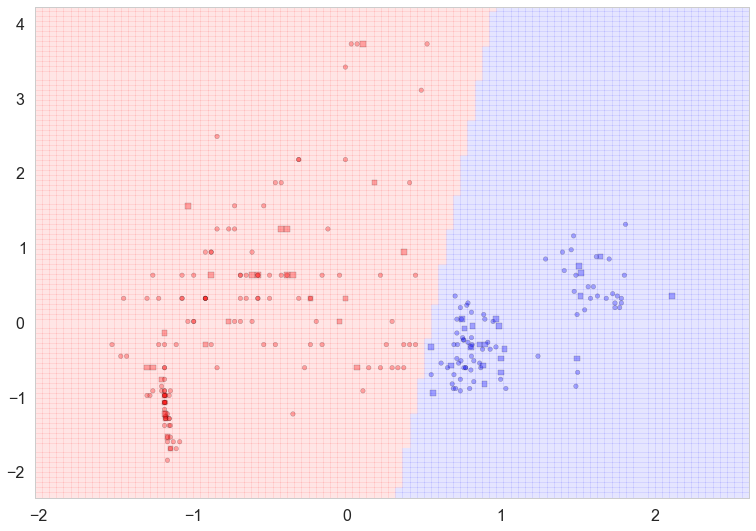

In [64]:
clflog = LogisticRegression()
parameters = {"C": [0.01, 0.1, 1, 10, 100]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, dfnosouth, ['linoleic','stearic'],'regionstring', "Sardinia", standardize=True)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, alpha=0.3, psize=20);

In [65]:
from sklearn.svm import SVC # "Support Vector Classifier"

def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

We now carry out the same process using a SVM classfier. The SVM classifier also has a regularization parameter $C$ with exactly the same interpretation as the Logistic Regression regularization strength.

In [165]:
clf = SVC(kernel="linear")
parameters = {"C": np.logspace(-4, 3, num=50)}
thesvcfit, Xtr, ytr, Xte, yte = do_classify(clf, parameters, dfnosouth, ['linoleic','stearic'],'regionstring', "Sardinia")

BEST PARAMS {'C': 0.13894954943731375}
Accuracy on training data: 0.99
Accuracy on test data:     1.00


We plot the line dividing the two regions, the **discriminant** line, along with its margins, and the support vectors. Note that unlike the figure we showed earlier, some support vectors are inside the margin. This is related to the regularization, and is a slack which allows for misclassified examples, The basic idea is that we penalize a point for being on the wrong side of the decision boundary. When data are simply linearly separable as in the figure above, there is no penalty. But when this is not the case, regularization gives us the best model as one that balances a far margin with a low misclassificaton penalty. We shall talk more about these in chapter REF.

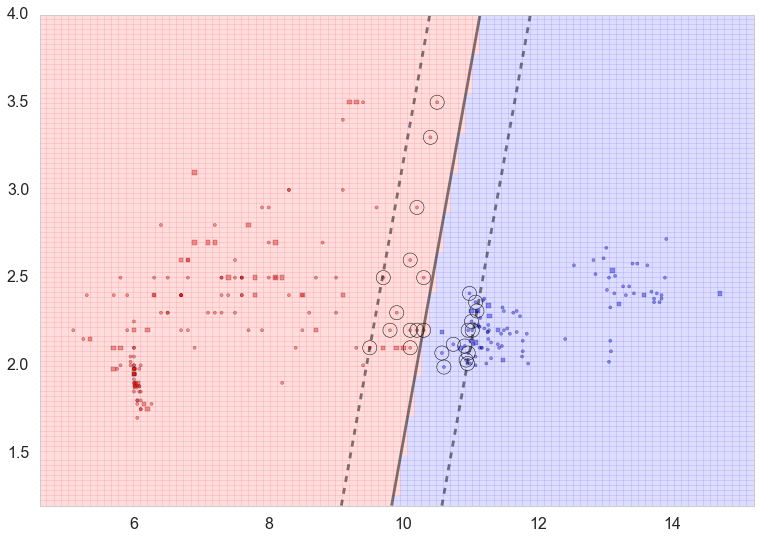

In [166]:
plt.figure()
ax=plt.gca()
ax,_,_=points_plot(ax, Xtr, Xte, ytr, yte, thesvcfit, alpha=0.4)
plot_svc_decision_function(thesvcfit, ax)
ax.scatter(thesvcfit.support_vectors_[:, 0], thesvcfit.support_vectors_[:, 1],
                s=200, facecolors='none')

The support vector machine works by minimizing a *decision risk* called the **hinge-loss**, which does not have a probabilistic interpretation such as the maximum-likelihood interpretation of Logistic Regression's log-loss. While later research(REF) has retrofitted probability models onto the SVM (more on why in chapter REF), the original SVM was concieved as a non-probabilistic model driven by the ERM school of learning (REF). 

HINGE LOSS DIAG

Currently, however, we seem to be missing the answer to possibly the most important question: how did out classifier do? So lets get to it!

###Evaluating a classifier

We briefly saw how we might evaluate a clasifier using the `score` function in `do_classify` in the examples above.

In [170]:
clf_l.score(Xtest_l, ytest_l), clflda.score(Xtest_l, ytest_l)

(0.92200000000000004, 0.92149999999999999)

Here the logistic regression classifier gives us a 92.2% accuracy on our test set. Thats way better than random guessing, which would give us 50%, of course. Given that men and women can have very conflated heights and weights, this is a pretty good classification. LDA gives us an almost identical answer, not surprisingly, since its classification probabilities $P(y|x)$ are identical to Logistic regression.

But the accuracy score is not the whole story. In the example of the cancer patient above, false negatives, where we misclassified patients with cancer as those not having it, were very disastrous. We'll see how to deal with such asymmetric risk in the next two chapters, but before we even get to that, we need to be able to characterize the performance of a classifier in terms of false positives, false negatives, and all that.

The confusion matrix is the basic starting point. Let us see what the confusion matrix looks like for our Logistic Regression classifier:

In [174]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest_l, clf_l.predict(Xtest_l))

array([[882,  72],
       [ 84, 962]])

The way to read this matrix is from row to columns. The first row corresponds to samples observed to be in class 0, in our case females. The first item corresponds to **true negatives**: those 0 that are predicted to be 0, ie, females predicted to be females. The next number is the **false positives**, the females (0) predicted to be males (1). Then we move to the next row, which consists of samples observed 1 (males). The first number there is males predicted to be females, or **false negatives**. The second number in the second row is the number of **true positives**, or observed 1 (males) which are predicted to be 1(male) as well.

(Incase you are wondering why the word negatives is used for 0, this is just a convention. In some software packages and books, the classes are labelled 1 and -1, and there this language makes much more sense. In `scikit-learn` the labels used are 1 and 0, and we'll refer to a sample belonging to the 0 class as labelled negative, even though this is an abuse of the language.)

The entire structure can be seen schematically in the diagram below.

![confmatrix](images/bookimages/confusionmatrix.png)

A question that may have arisen in your head now is: given that we used probability estimation in the Logistic Regression classifier, how do we now fold this information into making decisions that maximize any of these metrics, or for matter minimize the 1-0 loss or maximize the accuracy (which we talked about right at the beginning of this chapter. In this case `sklearn` continues to use the log-loss as a surrogate decision risk for the 1-0 loss on the validation sets. The short of it is that decision risk comes in at the decision making stage on the validation set. (The exception is in the full ERM case like the SVM, where we use the same hinge loss on both the training and validation steps as a decision risk). We shall explain all of this  in the next chapter. 

But, in the meanwhile, there is a loose end to tie up. When we talked about generative models earlier, we said that we'd need to model $P(\v{x}|y, \theta_y)$, the features belonging to one class, but didnt indicate how. And in general, we might want to model the input feature distribution $P(x)$. How do we solve either of these problems? These fall under the rubric of density estimation.

### Density estimation and Unsupervized learning

The basic idea in unsupervised learning is to find a compact representation of the data $\{\v{x}_1, \v{x}_2, ..., \v{x}_n\}$, whether these $\v{x}$ come from a class conditional probability distribution like those for males or females, or from all the samples. In other words, we are trying to *estimate a feature distribution* in one case or the other. This is, of course the fundamental problem of statistics, the estimation of probability distributions from data. 

We saw an example of this both in chapter REF and earlier in this chapter, where we used the maximum likelihood method in logistic regression. There we were trying to estimate $P(y|\v{x}, \v{w})$, a 1-D distribution in y, by finding the most appropriate parameters $\v{w}$. Here we are trying to find some parametrization $\theta_y$ for $P(x|y, \theta_y)$ or $\v{\theta}$ in general for $P(x)$. 

But the basic method we will use remains the same: find the maximum likelihood, or, choose some probability distributions with parameters $\v{\theta}$, find the probability of each point of data if the data had come from this distribution, multiply these probabilities, and maximize the whole thing with respect to the parameters. (Equivalently we minimize the risk defined as the negative of the log-likelihood). 

Consider our heights and weights problem again. Suppose I did not tell you the labels: ie which samples were males and which samples were females. The data would then look like this:

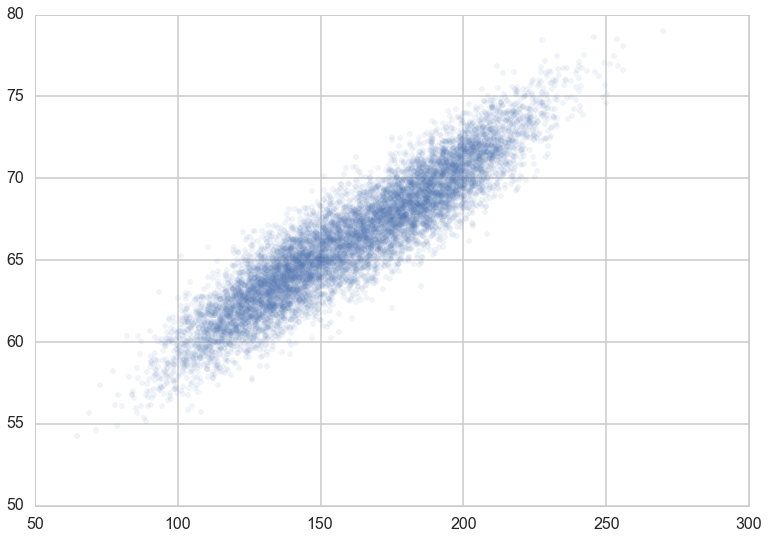

In [180]:
plt.plot(df.Weight, df.Height, '.', alpha=0.08);

The data looks vaguely elliptical and has two "clusters". Besides we know that heights and weights have normal distributions associated with them. So we decide to fit these features, with no knowledge of labels, with a mixture of two 2-D normal distributions. 

$$P(x) = \lambda G_0(\v{x},\theta_0) + (1 - \lambda) G_1(\v{x},\theta_1) $$

What we are doing is a probability distribution estimation on these height and weight features, by fitting for the parameters of whats known as a "mixture of gaussians". Note these are not the per label gaussians we fit before in LDA: rather, there are no labels any more, so this is just a mixture of gaussians. This is just a density estimation.

At this point, you may object, saying that we know from generative classifiers that we can find $P(x)$ as:

$$P(x) = \sum_y P(x|y, \theta_y) P(y).$$

You are right, if you knew the labels. But remember, I have taken these labels away from you, and thus there are no $y$'s, and this formula does not hold any more.

But your objection also makes sense: why not right the input density $P(x)$ as a sum of components, each of which is some other probability distribution. This is the notion of **clustering**: an attempt to find hidden structure in the data. So we can always write:

$$P(x) = \sum_z \lambda_z P(x|z, \theta_z),$$

where $z$ is some **hidden** variable which indexes the number of clusters in our problem. This is a variant of the idea behind the famous **kmeans** clustering algorithm, which we shall encounter in chapter REF.

So thats what we do below here, using two clusters based on our visual reconnoiter of the density in the graph above:

In [190]:
from sklearn.mixture import GMM
Xall=np.concatenate((Xtrain_l, Xtest_l))
n_clusters=2
clfgmm = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm.fit(Xtrain_l)
print clfgmm
gmm_means=clfgmm.means_
gmm_covar=clfgmm.covars_
print gmm_means, gmm_covar

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 136.7039029    63.74937632]
 [ 186.94950957   69.0689406 ]] [[ 393.55044723   47.17901361]
 [  47.17901361    7.77005769]]


How do we use these gaussians to assign clusters? Just like we did in the generative case, we can ask, whicg Gaussian is higher at a particular sample. We'll cluster that sample under an artificial label created by that cluster. Note again there was no training data! 

We plot the results below.

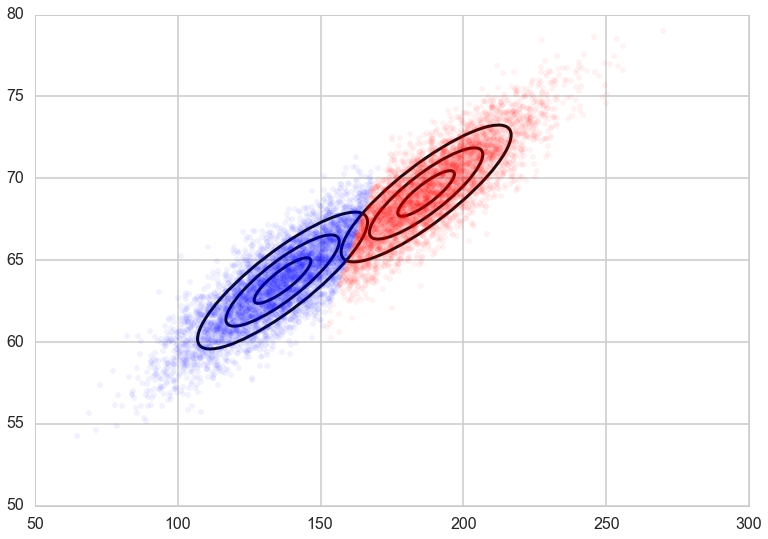

In [191]:
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
gmm_labels=clfgmm.predict(Xall)
for k, col in zip(range(n_clusters), ['blue','red']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.05)

The results of the clustering and the ellipses look markedly similar to what we haved in the supervized generative LDA case. This is not surprising. This data has the structure of having come from gaussians, even if we take away the label (male or female) that represents which gaussian which sample comes from. Thus, sometimes, a lot of information can be obtained from the structure of the features alone. 

This leads to an interesting corollary. If a lot of information is encoded in the structure of the features alone, we can get away with labelling only a few data points in a data set to make a good classifier: the process is called **semi-supervised** learning, and is very useful in the real-world since the cost of labelling data can be quite high.

How do we know, a-priori, that two is the right number of clusters? We can try and fit a mixture of 3 gaussians

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 161.52127132   66.20507208]
 [ 131.8335175    63.28324787]
 [ 192.35674906   69.70070415]] [[ 329.05502229   40.25645672]
 [  40.25645672    7.01783641]]


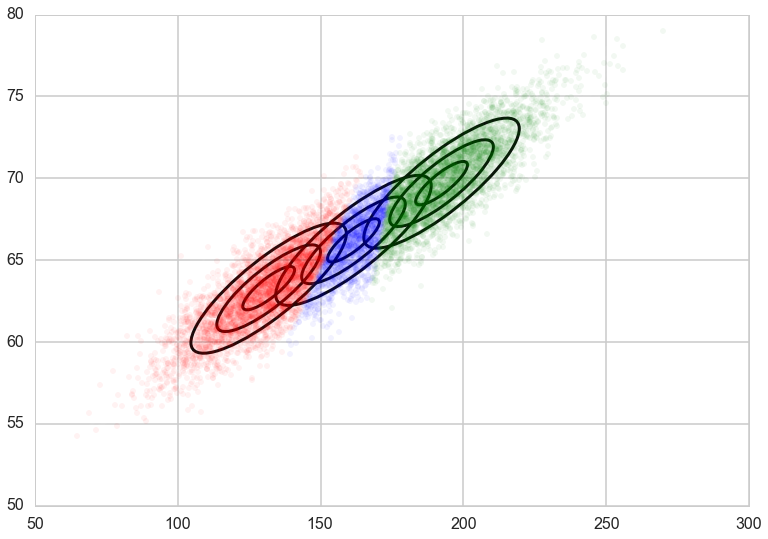

In [199]:
n_clusters=3
clfgmm3 = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm3.fit(Xtrain_l)
print clfgmm
gmm_means=clfgmm3.means_
gmm_covar=clfgmm3.covars_
print gmm_means, gmm_covar
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[2], gmm_covar, 'k')
gmm_labels=clfgmm3.predict(Xall)
for k, col in zip(range(n_clusters), ['blue','red', 'green']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.05)

In [198]:
clfgmm.aic(Xall), clfgmm3.aic(Xall) 

(132992.181692991, 132996.51990293068)

Which is a better fit? Our prior knowledge leads us to think the former. But to evaluate it formally we must do so based on the likelihood of the models, and their complexity, and we shall show this rigorously later in chapter REF (stats:density estimation).

SHOULD WE HAVE PROB CALLIBRATION AND K-MEANS?